In [1]:
!pip install d2l==1.0.3


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [3]:
# Defining the l2 norm penalty
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [4]:
# Defining the Model
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [5]:
# The following code fits our model on the training set with 20 examples and evaluates it on the validation set with 100 examples.
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

# Training with Weight Decay Scratch
def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))
    return model  # Return the trained model

L2 norm of w: 0.008883705362677574


WeightDecayScratch()

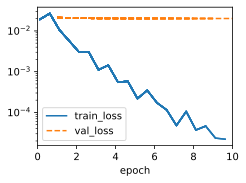

In [6]:
# We now run this code with lambd = 0, disabling weight decay
train_scratch(0)

In [7]:
#Note that the training error increases but the validation error decreases. This is precisely the effect we expect from regularization.
train_scratch(3)

L2 norm of w: 0.0013916274765506387


WeightDecayScratch()

In [8]:
# Below, we specify the weight decay hyperparameter directly through weight_decay when instantiating our optimizer.
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.013284213840961456


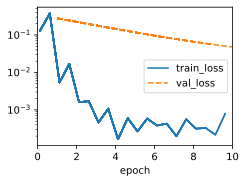

In [9]:
# This version runs faster and is easier to implement, though it look likes the one above
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

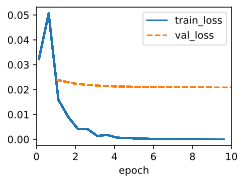

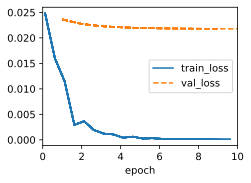

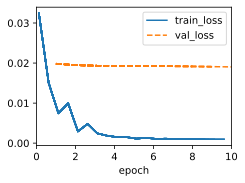

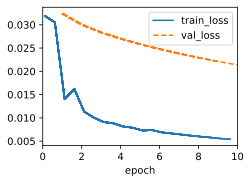

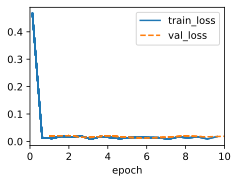

In [17]:
# Loop through lambda values
lambda_values = [0.001, 0.01, 0.1, 1, 10, 100]
for lambd in lambda_values:
    # Training with Weight Decay Scratch
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    trainer.fit(model, data)

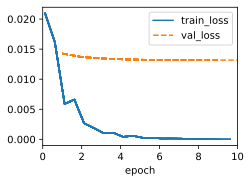

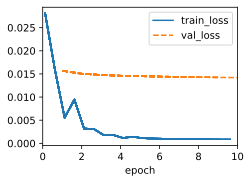

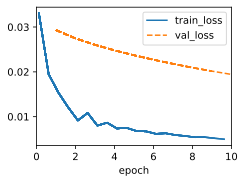

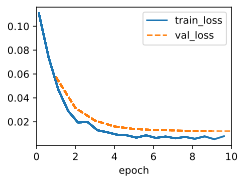

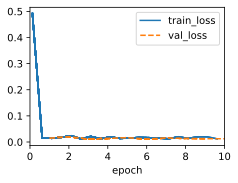

In [29]:
# Data Initialization
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

# Lists to store results
lambda_values = [0.001, 0.01, 0.1, 1, 10, 100]
train_losses = []
val_losses = []

# Loop through lambda values
for lambd in lambda_values:
    # Training with Weight Decay Scratch
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    trainer.fit(model, data)

    # Extract data tensors from DataLoader
    train_data = next(iter(data.get_dataloader(train=True)))
    val_data = next(iter(data.get_dataloader(train=False)))

    # Calculate losses
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        train_loss = model.loss(model(train_data[0]), train_data[1])
        val_loss = model.loss(model(val_data[0]), val_data[1])

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

In [30]:
# Plotting
plt.plot(lambda_values, train_losses, label='Training Loss')
plt.plot(lambda_values, val_losses, label='Validation Loss')
plt.xscale('log')
plt.xlabel('Lambda (Weight Decay)')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [162]:
# Saving the Nueral Network
# Specify the path where you want to save the model parameters
save_path = 'model_parameters.pth'

# Save the model parameters
torch.save(model.state_dict(), save_path)